# Problem 4

**(Carlin, Gelfand and Smith, 1992)**

**Let $y_1, ..., y_n$ be a sample from a Poisson distribution**
**for which there is a suspicion of a change point $m$ along the observation process**
**where the means change, $m = 1, ..., n$.**
**Given $m$, $y_i ∼ Poi(\theta)$, for $i = 1, ..., m$ and $y_i ∼ Poi(\phi)$,**
**for $i = m + 1, ..., n$.**

**The model is completed with independent prior distributions $\theta ∼ Gamma(\alpha, \beta)$,**
**$\phi ∼ Gamma(\gamma, \delta)$ and $m$ uniformly distributed over ${1, ..., n}$**
**where $\alpha, \beta, \gamma, \delta$ are known constants.**

**The data in file mining-data.r consists of counts of coal mining disasters in Great Britain by year from 1851 to 1962.**

In [1]:
##################################################################
## DATA:
## Carlin, Gelfand and Smith (1992): Hierarchical Bayesian Analysis of Changepoint Problems
## Counts of coal mining disasters in Great Britain by year from 1851 to 1962.
##################################################################
mining_data = [
    4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,3,
    4,2,5,2,2,3,4,2,1,3,2,2,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,0,3,
    2,2,0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,3,3,1,1,2,1,1,
    1,1,2,4,2,0,0,0,1,4,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
    ]
print(len(mining_data)) #112

112


## (a)
**Describe a Gibbs sampling algorithm to obtain samples from the joint posterior distribution.**

-> please see the note attached.


## (b), (c), and (d)

**(b) Specify values of the fixed hyperparameters, $\alpha, \beta, \gamma$ and $\delta$ and justify your choices.**

**(c) Implement your sampling algorithm in part (a) and summarize the posterior distribution**
**using point estimates and interval estimates of the parameters.**
**Provide interpretations of the inference in layman’s word.**

**(d) Perform prior sensitivity examination. Refit the model with different sets of the fixed**
**hyperparameter values and examine if the prior distributions have an undesired influence on the posterior inference.**


Here, I will try four sets of hyperparameters.

1. $[\alpha, \beta, \gamma, \delta] = [0.01, 0.01, 0.01, 0.01]$
: Cause, I don't have any information! This hyperpameter set gives us quite a vague prior distribution.

2. $[\alpha, \beta, \gamma, \delta] = [0.01, 0.01, 1000, 1000]$
3. $[\alpha, \beta, \gamma, \delta] = [1000, 1000, 0.01, 0.01]$
4. $[\alpha, \beta, \gamma, \delta] = [1000, 1000, 1000, 1000]$
These three are just for the purpose of (d), a kind of prior sensitivity examination.

Let's implement a Gibbs sampler first. From my note, we already know that 
- $\theta|\phi, m, y \sim gamma(\alpha + \sum_{i=1}^m y_i, \beta + m)$
- $\phi|\theta, m, y \sim gamma(\gamma + \sum_{i=m+1}^n y_i, \delta + n - m)$
- $\pi(m|\theta, \phi, y) \propto \theta^{\sum_{i=1}^m y_i} \phi^{\sum_{i=m+1}^n y_i} e^{-m\theta + m\phi}$

For m, I use MH within the gibbs algorithm. As a proposal, I set discrete $y|y^{t-1} \sim$ uniform(max($0$, $y^{t-1}-10$), min($n$, $y^{t-1}+10)$) on the domain ${1,2,...,n=112}$.

In [2]:
from random import gammavariate, normalvariate, uniform, seed, randint
from math import log, exp
from functools import partial

import numpy as np

from MCMC_MH_Core import MCMC_MH, MCMC_Diag
from MCMC_Gibbs_Core import MCMC_Gibbs
from newton import NewtonUnconstrained

seed(20220227)

class Gibbs_with_MH_p4(MCMC_Gibbs):
    def __init__(self, initial, data, hyper_param): #override
        self.MC_sample = [initial]
        self.data = data
        self.n = len(data)
        
        #hyper_param: [alpha, beta, gamma, delta]
        self.hyper_param =  hyper_param
    
    def get_data_sum(self):
        if not hasattr(self, 'data_sum'):
            self.data_sum = sum(self.data)
        return self.data_sum

    def full_conditional_sampler_theta(self, last_param):
        #last_param: [theta, phi, m]
        #hyper_param: [alpha, beta, gamma, delta]
        alpha = self.hyper_param[0]
        beta = self.hyper_param[1]
        m = last_param[2]
        shape = alpha + sum(self.data[:m])
        rate = beta + m
        new_theta = gammavariate(shape, 1/rate)
        
        new_sample = [x for x in last_param]
        new_sample[0] = new_theta
        return new_sample


    def full_conditional_sampler_phi(self, last_param):
        #last_param: [theta, phi, m]
        #hyper_param: [alpha, beta, gamma, delta]
        gamma = self.hyper_param[2]
        delta = self.hyper_param[3]
        m = last_param[2]
        shape = gamma + sum(self.data[m:])
        rate = delta + self.n - m
        new_phi = gammavariate(shape, 1/rate)
        
        new_sample = [x for x in last_param]
        new_sample[1] = new_phi
        return new_sample

    def full_conditional_sampler_m(self, last_param):
        #last_param: [theta, phi, m]
        #hyper_param: [alpha, beta, gamma, delta]
        m = last_param[2]

        def log_target_density_kernel(eval_pt, last_param, data):
            eval_pt = int(eval_pt[0])
            theta = last_param[0]
            phi = last_param[1]

            first_m_data_sum = sum(data[:eval_pt])
            last_data_sum = sum(data[eval_pt:])

            log_kernel = first_m_data_sum*log(theta) + last_data_sum*log(phi) - eval_pt*theta + eval_pt+phi
            return log_kernel

        def log_proposal_density(from_smpl, to_smpl, n, window):
            if from_smpl[0] - window < 0:
                log_density = -log(from_smpl[0] + window + 1)
            if from_smpl[0] + window > n:
                log_density = -log(n - from_smpl[0] + window + 1)
            else:
                log_density = -log(window*2 + 1)
            return log_density
            
        def proposal_sampler(last, n, window):
            return [randint(max(0, last[0]-window), min(n, last[0]+window))]

        
        log_target_density_kernel_with_data = partial(log_target_density_kernel, last_param=last_param, data=self.data)
        proposal_sampler_with_data = partial(proposal_sampler, n=self.n, window=10)
        log_proposal_density_with_data = partial(log_proposal_density, n=self.n, window=10)
        mcmc_mh_inst = MCMC_MH(log_target_density_kernel_with_data, log_proposal_density_with_data, proposal_sampler_with_data, [m], random_seed=uniform(0,1))
        mcmc_mh_inst.generate_samples(1, verbose=False)
        new_m = mcmc_mh_inst.MC_sample[-1][0]
        
        new_sample = [x for x in last_param]
        new_sample[2] = new_m
        return new_sample

    def gibbs_sampler(self): #override
        last = self.MC_sample[-1]
        new = [x for x in last] #[theta, phi, m]

        #update new
        new = self.full_conditional_sampler_theta(new)
        new = self.full_conditional_sampler_phi(new)
        new = self.full_conditional_sampler_m(new)
        self.MC_sample.append(new)

## $[\alpha, \beta, \gamma, \delta] = [0.01, 0.01, 0.01, 0.01]$

estimated running time:  0.0 min  2.969026565551758 sec
iteration 20000 / 100000
iteration 40000 / 100000
iteration 60000 / 100000
iteration 80000 / 100000
iteration 100000 / 100000  done! (elapsed time for execution:  0.0 min  2.802990436553955 sec)


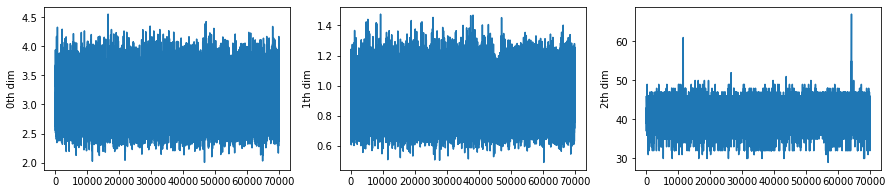

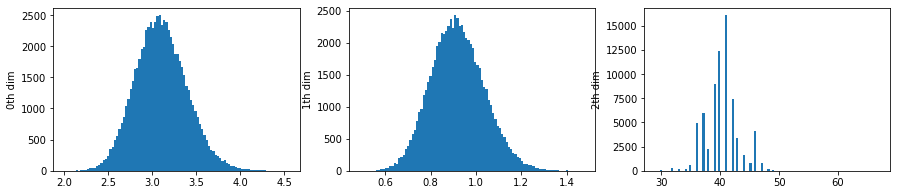

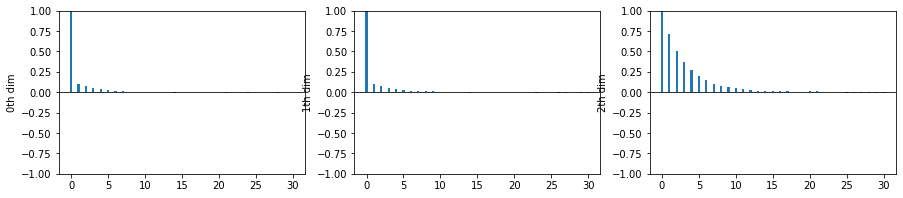

mean:  [3.1031652816708784, 0.9192291420254507, 40.36366623333952]
95% CI:  [[2.560669347797404, 3.709106746009245], [0.7013710202606548, 1.1628072109419023], [36.0, 46.0]]


In [3]:
hyper_param_set1 = [0.01, 0.01, 0.01, 0.01] #hyper_param: [alpha, beta, gamma, delta]
gibbs_inst_1 = Gibbs_with_MH_p4([2,2,10], mining_data, hyper_param_set1)
gibbs_inst_1.generate_samples(100000, print_iter_cycle=20000)

gibbs_diag_inst_1 = MCMC_Diag()
gibbs_diag_inst_1.set_mc_sample_from_MCMC_MH(gibbs_inst_1)
gibbs_diag_inst_1.burnin(30000)
gibbs_diag_inst_1.show_traceplot((3,1))
gibbs_diag_inst_1.show_hist((3,1))
# gibbs_diag_inst_1.show_scatterplot(0,1)
gibbs_diag_inst_1.show_acf(30, (3,1))
print("mean: ", gibbs_diag_inst_1.get_sample_mean())
print("95% CI: ", gibbs_diag_inst_1.get_sample_quantile([0.025, 0.975]))

Note that 0th dim is $\theta$, 1th dim is $\phi$, and 2th dim is $m$.

As a MCMC result, everything (convergence, autocorrelation, etc) seems good.

The posterior mean value for each parameters are $\theta^* = 3.1, \phi^* = 0.9$, and $m^* = 40.36$,
which we can use as a point estimator for each parameter.
In other words, $y_1,...,y_{40}$ follow $pois(3.1)$, and $y_{41},...,y_{121}$ follow $pois(0.9)$.
Or, if you want to use the mode, $m^{**}=41$, so $y_{41}$ can be included in the first group.
It depends on your modelling of loss function.

95% credible interval can be interpreted as a set that each parameter has 95% probability to be in that range.
For example, the change point parameter $m$ is between $36$ and $46$ with 95% probability.
Likewise, we can get interpretations for $\theta$ and $\phi$.

## $[\alpha, \beta, \gamma, \delta] = [0.01, 0.01, 1000, 1000]$

estimated running time:  0.0 min  3.017902374267578 sec
iteration 20000 / 100000
iteration 40000 / 100000
iteration 60000 / 100000
iteration 80000 / 100000
iteration 100000 / 100000  done! (elapsed time for execution:  0.0 min  3.0495853424072266 sec)


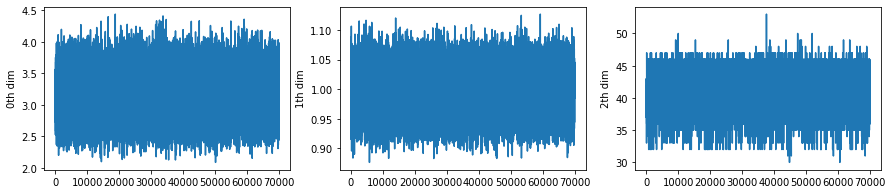

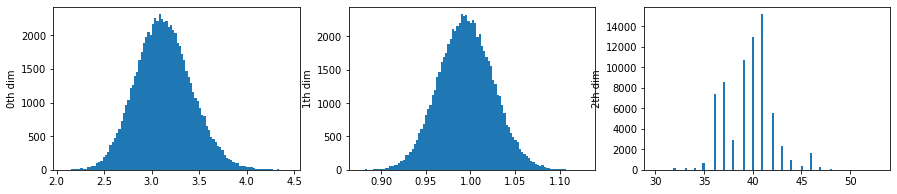

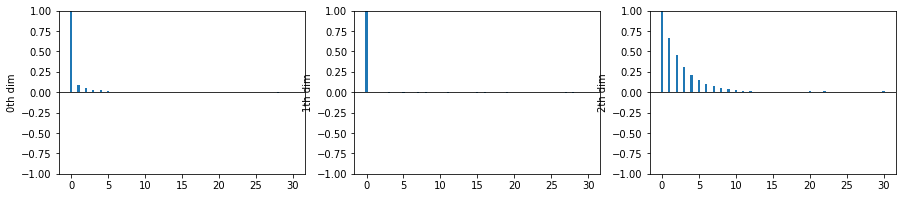

mean:  [3.1300313838811564, 0.9950027595263842, 39.609019871144696]
95% CI:  [[2.5837588716014044, 3.733101705727057], [0.9361034132884776, 1.0556850842951473], [36.0, 46.0]]


In [4]:
hyper_param_set2 = [0.01, 0.01, 1000, 1000] #hyper_param: [alpha, beta, gamma, delta]
gibbs_inst_2 = Gibbs_with_MH_p4([2,2,10], mining_data, hyper_param_set2)
gibbs_inst_2.generate_samples(100000, print_iter_cycle=20000)

gibbs_diag_inst_2 = MCMC_Diag()
gibbs_diag_inst_2.set_mc_sample_from_MCMC_MH(gibbs_inst_2)
gibbs_diag_inst_2.burnin(30000)
gibbs_diag_inst_2.show_traceplot((3,1))
gibbs_diag_inst_2.show_hist((3,1))
# gibbs_diag_inst_2.show_scatterplot(0,1)
gibbs_diag_inst_2.show_acf(30, (3,1))
print("mean: ", gibbs_diag_inst_2.get_sample_mean())
print("95% CI: ", gibbs_diag_inst_2.get_sample_quantile([0.025, 0.975]))

Note that 0th dim is $\theta$, 1th dim is $\phi$, and 2th dim is $m$.

Since $\phi$'s hyperprior is super strong, the marginal posterior of $\phi$ get pulled to 1, the hyperprior's mean.
Luckly, the posterior mean value was near 1 with vague prior as well, the fitting result for this case seems still fine.

Here, I skip an interpretation cause the way is the same to previous case. Only numbers are changed.

## $[\alpha, \beta, \gamma, \delta] = [1000, 1000, 0.01, 0.01]$

estimated running time:  0.0 min  4.981279373168945 sec
iteration 20000 / 100000
iteration 40000 / 100000
iteration 60000 / 100000
iteration 80000 / 100000
iteration 100000 / 100000  done! (elapsed time for execution:  0.0 min  3.07295298576355 sec)


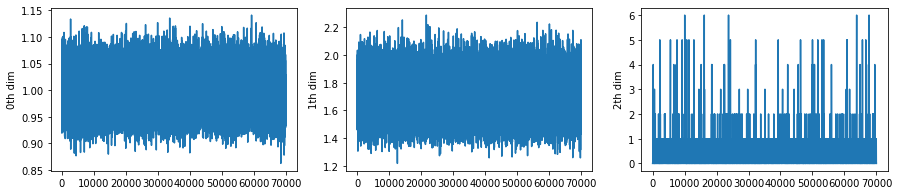

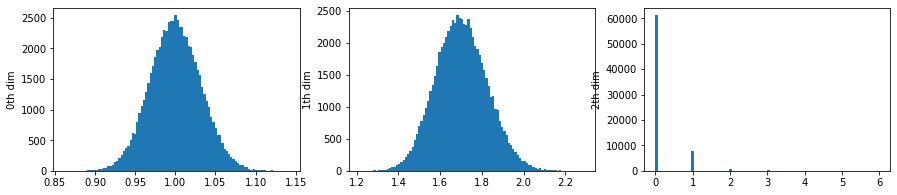

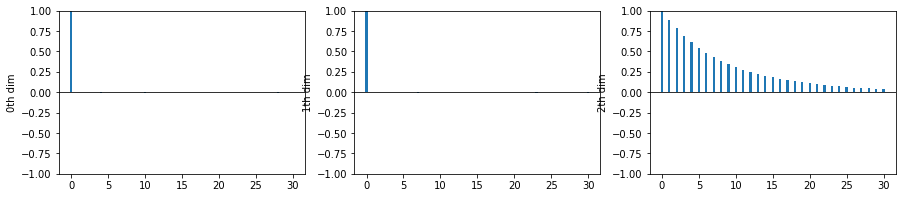

mean:  [1.000294042259073, 1.7022974797302082, 0.15035499492864388]
95% CI:  [[0.939099043397785, 1.0631754494922565], [1.4695008530442213, 1.9524319046960652], [0.0, 1.0]]


In [5]:
hyper_param_set3 = [1000, 1000, 0.01, 0.01] #hyper_param: [alpha, beta, gamma, delta]
gibbs_inst_3 = Gibbs_with_MH_p4([2,2,10], mining_data, hyper_param_set3)
gibbs_inst_3.generate_samples(100000, print_iter_cycle=20000)

gibbs_diag_inst_3 = MCMC_Diag()
gibbs_diag_inst_3.set_mc_sample_from_MCMC_MH(gibbs_inst_3)
gibbs_diag_inst_3.burnin(30000)
gibbs_diag_inst_3.show_traceplot((3,1))
gibbs_diag_inst_3.show_hist((3,1))
# gibbs_diag_inst_3.show_scatterplot(0,1)
gibbs_diag_inst_3.show_acf(30, (3,1))
print("mean: ", gibbs_diag_inst_3.get_sample_mean())
print("95% CI: ", gibbs_diag_inst_3.get_sample_quantile([0.025, 0.975]))

Again, note that 0th dim is $\theta$, 1th dim is $\phi$, and 2th dim is $m$.

This time, theta is pulled near 1 by its super-strong hyperprior.
I skip an strict interpretation one more time, cause the way is the same to previous case.

Comparing this case to the previous case with vague hyperprior, the $\theta$'s marginal posterior is changed very much.
As a result, other parameters also be affected. But the effect is not very desirable. 
For example, we may choose m=0 as a MAP. It means that the change point is the first point. But when we observe the data by our eyes, it is not a convincing argument.
However, of course, it is still 'the best' on the conditionality principle, if we assume that the prior represents the best prior information appropriately.

## $[\alpha, \beta, \gamma, \delta] = [1000, 1000, 1000, 1000]$

estimated running time:  0.0 min  3.9899349212646484 sec
iteration 20000 / 100000
iteration 40000 / 100000
iteration 60000 / 100000
iteration 80000 / 100000
iteration 100000 / 100000  done! (elapsed time for execution:  0.0 min  3.3195395469665527 sec)


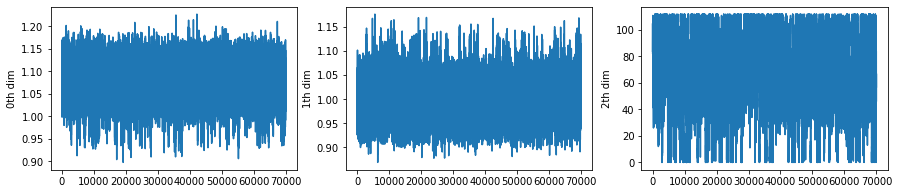

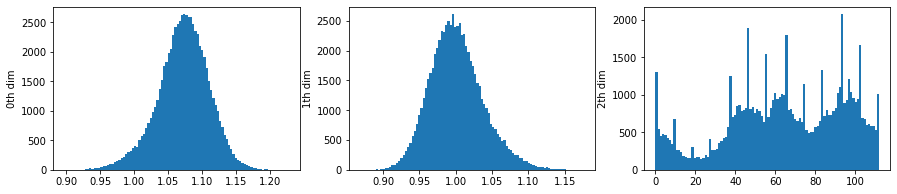

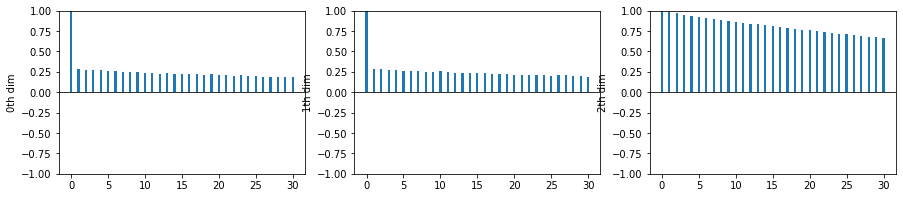

mean:  [1.0720967070054706, 1.0013504121563852, 64.59034870930415]
95% CI:  [[0.989770869308934, 1.1409165821400773], [0.9365106133254881, 1.0827810363665753], [2.0, 109.0]]


In [6]:
hyper_param_set4 = [1000, 1000, 1000, 1000] #hyper_param: [alpha, beta, gamma, delta]
gibbs_inst_4 = Gibbs_with_MH_p4([2,2,10], mining_data, hyper_param_set4)
gibbs_inst_4.generate_samples(100000, print_iter_cycle=20000)

gibbs_diag_inst_4 = MCMC_Diag()
gibbs_diag_inst_4.set_mc_sample_from_MCMC_MH(gibbs_inst_4)
gibbs_diag_inst_4.burnin(30000)
gibbs_diag_inst_4.show_traceplot((3,1))
gibbs_diag_inst_4.show_hist((3,1))
# gibbs_diag_inst_4.show_scatterplot(0,1)
gibbs_diag_inst_4.show_acf(30, (3,1))
print("mean: ", gibbs_diag_inst_4.get_sample_mean())
print("95% CI: ", gibbs_diag_inst_4.get_sample_quantile([0.025, 0.975]))

Still, note that 0th dim is $\theta$, 1th dim is $\phi$, and 2th dim is $m$.

Finally, both $\theta$ and $\phi$ are pulled near 1 by their hyperprior.
As a (side)effect, the traceplot of $m$ is varying over 0 to n=112, with too high autocorrelation.
I think we may evaluate that $m$ fails to converge.
This makes a posterior inference over m difficult.


To sum up, hyperprior distributions can have an undesired influence on the posterior and its inference.
At the same time, we can say that this model is not (so-much) robust. (I think 1000 was too big a number to this model!)